In [1]:
%pip install seaborn --quiet
%pip install scipy --quiet
%pip install statsmodels --quiet

!pip install plotly --quiet
!pip install datetime --quiet
!pip install psycopg2-binary --quiet
!pip install prophet --quiet
!pip install scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
import datetime as dt
import re

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

%matplotlib inline 
import seaborn as sns
from plotly.subplots import make_subplots

pio.renderers.default = "iframe"
from shuqing_price_data import *

plt.style.use("fivethirtyeight")
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)
import pickle

import psycopg2
from sqlalchemy import create_engine, text

from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from bifrost.auth.drive import MSDrive
from io import StringIO

from bifrost.auth.drive import MSDrive

from collections import Counter
import math

In [7]:
sql_query = """
select 
*
from ext_enrich_main_aviation_insight_hub.l6_ss_waterfall_summary invoice
left  join 
(
select cust_key,
grn,
soldto_mdm_partner_id,
sector, customer_name,
customer_country,

customer_external_lens,
customer_route_to_market,
customer_marketing_segment
from ext_enrich_main_aviation_insight_hub.l6_ss_customer_combined
where sector ='General Aviation')cust
on invoice.cust_key = cust.cust_key
left join 
(select 
mdm_partner_id ,
erp_id,
price_group,
split_part(price_list,'-',1 ) as price_list_type,
split_part(price_list,'-',2) as price_list_desc
from ext_conform_main_aviation.l41_dim_customer
where  customer_account_status ='ACTIVE'
and sector='General Aviation')c 
on cust.soldto_mdm_partner_id = c.mdm_partner_id

left join ext_enrich_main_aviation_insight_hub.l6_ss_mapping_combined MP
ON invoice.trx_loc_key = MP.dim_loc_key
left join 
(select dim_loc_key,
region,
location_name,
location_country,
location_type
from ext_enrich_main_aviation_insight_hub.l6_ss_location)LOC
ON MP.sem_key = LOC.dim_loc_key

where invoice.pricing_date > timestamp'2022-01-01' and invoice.pricing_date < current_date 
and cust.sector='General Aviation'
"""

In [9]:
sql_loc_seg="""
SELECT locationid,
deliverypointid,
mdm_dp_identifier,
operationtype,
soluslocation,
deliverypointstatus

FROM ext_conform_main_aviation.l4_dim_delivery_point loc

"""

In [5]:
sql_19 = """
select 
*
from ext_enrich_main_aviation_insight_hub.l6_ss_waterfall_summary invoice
left  join 
(
select cust_key,
grn,
soldto_mdm_partner_id,
sector, customer_name,
customer_country,

customer_external_lens,
customer_route_to_market,
customer_marketing_segment
from ext_enrich_main_aviation_insight_hub.l6_ss_customer_combined
where sector ='General Aviation')cust
on invoice.cust_key = cust.cust_key
left join 
(select 
mdm_partner_id ,
erp_id,
price_group,
split_part(price_list,'-',1 ) as price_list_type,
split_part(price_list,'-',2) as price_list_desc
from ext_conform_main_aviation.l41_dim_customer
where  customer_account_status ='ACTIVE'
and sector='General Aviation')c 
on cust.soldto_mdm_partner_id = c.mdm_partner_id

left join ext_enrich_main_aviation_insight_hub.l6_ss_mapping_combined MP
ON invoice.trx_loc_key = MP.dim_loc_key
left join 
(select dim_loc_key,
region,
location_name,
location_country,
location_type
from ext_enrich_main_aviation_insight_hub.l6_ss_location)LOC
ON MP.sem_key = LOC.dim_loc_key

where invoice.pricing_date >='2019-01-01' and invoice.pricing_date <= '2022-04-01' 
and cust.sector='General Aviation'
"""

In [8]:
def create_redshifts_connection(
    redshift_endpoint, redshift_user, dbname, port, redshift_pass,sql_query
):
    """
    create redshift db connection to bring sql into notebook

    """
    engine_string = "postgresql+psycopg2://%s:%s@%s:%d/%s" % (
        redshift_user,
        redshift_pass,
        redshift_endpoint,
        port,
        dbname,
    )
    engine = create_engine(engine_string)
    df = pd.read_sql_query(text(sql_query), engine)
    return df

In [9]:
df = create_redshifts_connection(
    redshift_endpoint, redshift_user, dbname, port, redshift_pass,sql_query
)

In [55]:
loc_seg=create_redshifts_connection(
    redshift_endpoint, redshift_user, dbname, port, redshift_pass,sql_loc_seg
)

In [11]:
# df19 = create_redshifts_connection(
#     redshift_endpoint, redshift_user, dbname, port, redshift_pass,sql_19
# )

In [6]:
band_price_mapping = pd.read_csv("band_price_mapping.csv")
hier_df = pd.read_csv("hier_df.csv")
# pros_df = pd.read_csv("pros.csv")
# pros_df19=pd.read_csv('pros19.csv')
# contract=pd.read_csv('contract_tmp.csv')

In [ ]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/pros_df.csv'
# pros_df=download_from_sharepoint(new_drive_id,new_item_path)

In [11]:
pros_df=pd.read_csv('pros_df_aug24.csv')

In [15]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/pros19_df.csv'
# pros_df19=download_from_sharepoint(new_drive_id,new_item_path)

In [56]:
mapping = Mapping(df, band_price_mapping, hier_df)
hier_df = mapping.clean_product_hier()
df = mapping.create_product_hier()

In [17]:
# mapping = Mapping(df19, band_price_mapping, hier_df)
# hier_df = mapping.clean_product_hier()
# df19 = mapping.create_product_hier()

In [102]:
pros_df=merge_process_pros_df(pros_df)
# pros_df19=merge_process_pros_df(pros_df19)

In [103]:
new_pros_df=check_band_price_multiple_delivery_points_per_shipping_points(pros_df)

# new_pros_df19=check_band_price_multiple_delivery_points_per_shipping_points(pros_df19)

In [104]:
tmp=pros_fill0_product_product_hierarchy_pa(new_pros_df)

new_pros_df['product']=tmp['product']

new_pros_df['product_hierarchy_pa']=tmp['product_hierarchy_pa']

In [105]:
sub_df_dict=create_sub_pros_df_for_joins(new_pros_df,160000)

In [106]:
sub_df_dict.keys()

dict_keys(['sub_df_1', 'sub_df_2', 'sub_df_3'])

In [107]:
merge1=merge_pros_invoice(df,sub_df_dict['sub_df_1'])

In [108]:
merge2=merge_pros_invoice(df,sub_df_dict['sub_df_2'])

In [109]:
merge3=merge_pros_invoice(df,sub_df_dict['sub_df_3'])

In [ ]:
# merge_df=merge_pros_invoice(df,new_pros_df)

In [110]:
merge=pd.concat([merge1,merge2])

In [111]:
merge_df=pd.concat([merge,merge3])

In [112]:
merge_df=pd.concat([merge,merge3])

In [113]:
merge_df.shape

(1079197, 124)

In [33]:
merge_df.shape

(1031740, 124)

In [114]:
number,index_list=check_merge_df_if_any_duplicates(merge_df)

merge_df=remove_band_price_merge_duplicates(merge_df,index_list)

In [44]:
# merge_df19=merge_pros_invoice(df19,new_pros_df19)

In [19]:
# number19,index_list19=check_merge_df_if_any_duplicates(merge_df19)

# merge_df19=remove_band_price_merge_duplicates(merge_df19,index_list19)

In [20]:
# merge_df_all=pd.concat([merge_df,merge_df19])

In [21]:
# merge_df_all.reset_index(drop=True,inplace=True)

In [115]:
merge_df.reset_index(drop=True,inplace=True)

#### Find trx product_id that doesn't match to PROS

In [ ]:
# merge_sales_doc=merge_df.sales_document.tolist()

In [46]:
# df.loc[~df.sales_document.isin(merge_sales_doc),['price_group','price_list_type']].set_index('price_group').to_dict()

In [47]:
# df.loc[~df.sales_document.isin(merge_sales_doc)].head()

In [48]:
# merge_df['product'].unique()

In [49]:
# df.loc[df.price_list_type.isnull(),['price_group','price_list_type']].set_index('price_group').to_dict()

## Contract df 

In [13]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/contract_df_June24.csv'

# contract24=download_from_sharepoint(new_drive_id,new_item_path)

# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/contract_df23.csv'
# contract23=download_from_sharepoint(new_drive_id,new_item_path)

In [138]:
contract24=pd.read_csv('contract24_aug.csv')

In [12]:
contract23=pd.read_csv('contract_df23.csv').drop('Unnamed: 0',axis=1)

In [140]:
contract=pd.concat([contract24,contract23])

In [14]:
contract23.approved_at.max()

'2022-02-08 14:25:46'

In [15]:
contract_aug=pd.read_csv('contract24_aug.csv')

In [143]:
contract_aug=contract_aug.loc[contract_aug.approved_at>'2024-08-05 16:46:17']

In [16]:
contract_all=contract23.append(contract_aug)

In [24]:
contract_new=check_contract_multiple_delivery_points_per_shipping_points(contract_all)

In [27]:
# count_delivery_point=contract_new.groupby(['tender','customer_grn','start_date','end_date','shipping_point','product','product_code',
#                                            'product_hierarchy_pa','net_price','price_group_id','price_list_type_id'],as_index=False)['delivery_point'].count()
# count_more_than_one=count_delivery_point.loc[count_delivery_point.delivery_point>1,'customer_grn'].count()

# count_delivery_point.loc[count_delivery_point.delivery_point>1].head()



In [28]:
check_contract_new_after_removing_duplicates(contract_new)

False

In [57]:
df,contract_new=preprocess_contract_invoice(df,contract_new)

In [87]:
# mapping = Mapping(df, band_price_mapping, hier_df)
# hier_df = mapping.clean_product_hier()
# df = mapping.create_product_hier()

In [58]:
no_match_df,merge_df=contract_merge_invoice(df,contract_new)
merge_df=clean_contract_merge_df(merge_df)

In [59]:
merge_df.shape

(365647, 118)

In [60]:
num,index_list=check_merge_df_if_any_duplicates(merge_df)

In [61]:
merge_df=remove_contract_merge_df_duplicates(merge_df,index_list)

In [62]:
check_merge_df_if_any_duplicates(merge_df)

False

In [36]:
# no_match_df.loc[no_match_df.band_price_id==0].trx_pro_key_new.unique()

In [31]:
# contract['product'].unique()

In [153]:
merge_df.shape

(258809, 118)

In [63]:
merge_df.shape[0]/df.shape[0]

0.16204048378892974

In [65]:
# columns_to_show=['price_group_id','price_list_type_id','tender','tender_desc','customer_grn','customer_grn_desc','delivery_point',
#                  'product_code','sales_org','supply_loc','shipping_point','sold_to','product_hierarchy_pa','product','index_code','start_date','end_date',
#    'currency_code' ,'uom_code', 'country_name' ,'net_price']

# band_price_columns=['band_price_desc','delivery_point','product_code','sales_org','supply_loc','shipping_point','product','product_hierarchy_pa',
#                    'start_date','end_date','currency_code','uom_code','country_name','net_price']

# transaction_columns=['delivery_date','sales_organisation','document_currency','trx_loc_key','delivery_point_code','grn','customer_country',
#                      'price_group','price_list_type','location_name','net_value']

# Clean Merge DF 

In [ ]:
merge_preprocessing_df = merge_preprocessing(merge_df_all) # use this when merge_df_all

In [117]:
merge_preprocessing_df = merge_preprocessing(merge_df)

In [118]:
merge_preprocessing_df.check_missing()[:5]

,total,percent,Type
sold_to,1079195,100.000000,datetime64[ns]
sold_to_desc,1076439,99.744624,datetime64[ns]
product_desc,974944,90.339929,object
product_hierarchy_pa_desc,97685,9.051654,object
location_type,1242,0.115086,object


In [119]:
final_df = merge_preprocessing_df.drop_missing_fillna()

In [103]:
# final_df.fillna('Unknown',inplace=True)

In [120]:
check_state(final_df)

False

In [121]:
final_df=convert_merge_df(final_df)

In [122]:
final_df=qty_mapping_function(final_df)
final_df=generate_revenue_by_qty(final_df)

In [33]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/band_price_July24_df.csv'

# export_sharepoint(final_df,new_drive_id,new_item_path)

In [ ]:
## start ffrom here, we use previous month df (band_price_April24_df.csv) it has the whole historical df to join with new_df 

In [28]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/band_price_April24_df.csv'
# previous_df=download_from_sharepoint(new_drive_id,new_item_path)

In [40]:
# previous_df=pd.read_csv('band_price_july24.csv').drop('Unnamed: 0',axis=1)

In [123]:
final_df=convert_band_price_date_to_str(final_df)

In [177]:
# new_df=remove_incremental_new_data_merge_df(previous_df,final_df)

In [178]:
# new_df=new_df.loc[new_df.pricing_date>'2024-07-04']

In [179]:
# new_df.pricing_date.max()

'2024-08-04'

In [54]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/band_price_June24_df_cleaned.csv'


# export_sharepoint(new_df,new_drive_id,new_item_path)

In [180]:
# overall_df=previous_df.append(new_df)

In [181]:
# overall_df=overall_df.drop_duplicates()

In [128]:
loc_pros_df=merge_pros_loc_seg_remove_duplicated_loctionid(final_df,loc_seg)

In [133]:
loc_pros_df.to_csv('band_price_sep24.csv',index=False)

In [3]:
tmp=pd.read_csv('band_price_sep24.csv')

In [5]:
tmp.loc[tmp.net_value==941.87215].head()

,pricing_date,delivery_date,sales_organisation,sales_document,local_currency,qty_in_m3,qty_in_usg,qty_in_litres,net_value,document_currency,l2_gross_profit_lc,l2_gross_profit_usd,l2_gross_profit_cso_lc,l2_gross_profit_cso_usd,l3_revenue_lc,l3_revenue_usd,l3_revenue_cso_lc,l3_revenue_cso_usd,l3_cost_lc,l3_cost_usd,l4_customer_price_lc,l4_customer_price_usd,l4_invoice_line_item_lc,l4_invoice_line_item_usd,l4_taxes_excise_duty_lc,l4_taxes_excise_duty_usd,l4_other_costs_lc,l4_other_costs_usd,l4_pre_airfield_sh_lc,l4_pre_airfield_sh_usd,l4_pre_airfield_transport_lc,l4_pre_airfield_transport_usd,l4_on_airfield_costs_lc,l4_on_airfield_costs_usd,l4_purchase_price_lc,l4_purchase_price_usd,delivery_method,fueling_method,delivery_point_code,grn,sector,customer_name,customer_country,customer_external_lens,customer_route_to_market,customer_marketing_segment,region,location_name,location_country,location_type,band_price_id,price_record_id,price_item_id,band_price,band_price_desc,location,location_desc,delivery_point,delivery_point_desc,product_code,product_code_desc,sales_org,sales_org_desc,supply_loc,supply_loc_desc,shipping_point,shipping_point_desc,product_hierarchy_pa,product_hierarchy_pa_desc,product,product_desc,start_date,end_date,currency_code,uom_code,country_name,price_basis,diff1,diff2,diff3,diff4,discount,price_decimal,net_price,month_number,year,month,band_price_cat,year_month,location_country_name,qty_in_hl,qty_mapping,revenue_qty_in_m3,revenue_qty_in_usg,revenue_qty_in_litres,revenue_qty_in_hl,revenue_mapping,locationid,deliverypointid,mdm_dp_identifier,operationtype,soluslocation,deliverypointstatus


In [134]:
cost_cols=[ c for c in final_df.columns if 'cost' in str(c) or 'transport' in str(c) or 'l4_pre_airfield' in str(c)  or 'l4_taxes_excise_duty' in str(c) 
           or 'l4_purchase_price' in str(c)]
cost_cols=['qty_in_m3','qty_in_usg','qty_in_litres','qty_in_hl']+cost_cols

cost_df=final_df.groupby(['band_price','year_month','band_price_cat','country_name','product','product_hierarchy_pa_desc','product_code_desc','net_price','sales_org_desc','supply_loc','uom_code',
                  'currency_code','qty_mapping','start_date','end_date','year','month','month_number','local_currency','customer_country','customer_external_lens','customer_route_to_market',
 'customer_marketing_segment' ],as_index=False)[cost_cols].sum()
cost_df=generate_cost_per_qty_mapping(cost_df)

In [135]:
final_df.head(1)

,pricing_date,delivery_date,sales_organisation,sales_document,local_currency,qty_in_m3,qty_in_usg,qty_in_litres,net_value,document_currency,l2_gross_profit_lc,l2_gross_profit_usd,l2_gross_profit_cso_lc,l2_gross_profit_cso_usd,l3_revenue_lc,l3_revenue_usd,l3_revenue_cso_lc,l3_revenue_cso_usd,l3_cost_lc,l3_cost_usd,l4_customer_price_lc,l4_customer_price_usd,l4_invoice_line_item_lc,l4_invoice_line_item_usd,l4_taxes_excise_duty_lc,l4_taxes_excise_duty_usd,l4_other_costs_lc,l4_other_costs_usd,l4_pre_airfield_sh_lc,l4_pre_airfield_sh_usd,l4_pre_airfield_transport_lc,l4_pre_airfield_transport_usd,l4_on_airfield_costs_lc,l4_on_airfield_costs_usd,l4_purchase_price_lc,l4_purchase_price_usd,delivery_method,fueling_method,delivery_point_code,grn,sector,customer_name,customer_country,customer_external_lens,customer_route_to_market,customer_marketing_segment,region,location_name,location_country,location_type,band_price_id,price_record_id,price_item_id,band_price,band_price_desc,location,location_desc,delivery_point,delivery_point_desc,product_code,product_code_desc,sales_org,sales_org_desc,supply_loc,supply_loc_desc,shipping_point,shipping_point_desc,product_hierarchy_pa,product_hierarchy_pa_desc,product,product_desc,start_date,end_date,currency_code,uom_code,country_name,price_basis,diff1,diff2,diff3,diff4,discount,price_decimal,net_price,month_number,year,month,band_price_cat,year_month,location_country_name,qty_in_hl,qty_mapping,revenue_qty_in_m3,revenue_qty_in_usg,revenue_qty_in_litres,revenue_qty_in_hl,revenue_mapping
0,2024-09-03,2024-09-03,HR01,0165513910,EUR,0.45,119.41,452.0,476.35,EUR,47.3,52.36,47.3,52.357,318.54,352.6,318.54,352.601,271.24,300.24,313.51,347.03,3.27,3.62,1.76,1.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271.24,300.24,Into Plane,Refueler Truck,PUY1,8290600,General Aviation,Vb Beteiligungs Gmbh & Co Kg,Austria,Corporate flight department / Private jet,Into - Plane Adhoc,Make my life easy,Europe,Pula,CROATIA,Airport,10003,70768915.0,575412.0,10003.0,PAP INTERNATIONAL -AG-XF,PUY,PUY - Pula,PUY01,PUY01 - INA,JETS,JETS,HR01,Air BP Croatia,8PUY,8PUY HR AIRPT Pula,PUY1,PUY1-HR AIRPT Pula,50101001.0,Non Bio Jet -L4-050101001,0,Unknown,2024-09-03,2024-09-09,USDC,UGL,CROATIA,219.1,72.0,0.0,0.0,0.0,0.0,5.0,291.1,9.0,2024.0,September,PAP INTERNATIONAL,2024-09,PUY - Pula-CROATIA,4.52,qty_in_usg,131.0,34760.25,131577.2,1315.77,revenue_qty_in_usg


In [136]:
cost_df.head(1)

,band_price,year_month,band_price_cat,country_name,product,product_hierarchy_pa_desc,product_code_desc,net_price,sales_org_desc,supply_loc,uom_code,currency_code,qty_mapping,start_date,end_date,year,month,month_number,local_currency,customer_country,customer_external_lens,customer_route_to_market,customer_marketing_segment,qty_in_m3,qty_in_usg,qty_in_litres,qty_in_hl,l3_cost_lc,l3_cost_usd,l4_taxes_excise_duty_lc,l4_taxes_excise_duty_usd,l4_other_costs_lc,l4_other_costs_usd,l4_pre_airfield_sh_lc,l4_pre_airfield_sh_usd,l4_pre_airfield_transport_lc,l4_pre_airfield_transport_usd,l4_on_airfield_costs_lc,l4_on_airfield_costs_usd,l4_purchase_price_lc,l4_purchase_price_usd,cost_per_qty_in_m3_lc,cost_per_qty_in_usg_lc,cost_per_qty_in_litres_lc,cost_per_qty_in_hl_lc,cost_mapping
0,10003.0,2022-01,PAP INTERNATIONAL,AUSTRALIA,0,Non Bio Avgas -L4-040302001,Avgas,577.89,BP Australia,8CUD,UGL,USDC,qty_in_usg,2022-01-01,2022-01-31,2022.0,January,1.0,AUD,Australia,Flying Club,Into - Plane Contracted,Make my life easy,0.1,26.29,99.52,0.9952,217.03,151.8,0.0,0.0,0.0,0.0,0.51,0.36,30.84,21.57,65.82,46.04,119.86,83.84,2170.0,8.0,2.0,218.0,cost_per_qty_in_usg_lc


In [137]:
cost_df.to_csv('cost_df_aug24.csv',index=False)

In [48]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/cost_June24_df.csv'

In [49]:
# export_sharepoint(cost_df,new_drive_id,new_item_path)

saving large file, in 97 chunks
File Uploaded successfully


# Clean Contract Merge DF

In [64]:
merge_preprocessing_df = contract_merge_preprocessing(merge_df)

In [65]:
merge_preprocessing_df.check_missing()

,total,percent,Type
ship_to,359994,100.000000,datetime64[ns]
fx_type_diff4,359994,100.000000,object
period,150975,41.938199,object
index_class_desc,150975,41.938199,float64
product_hierarchy_pa_desc,50170,13.936343,float64
price_list_desc,28663,7.962077,float64
region,7,0.001944,float64
location_type,7,0.001944,object
delivery_date,0,0.000000,float64
product_code,0,0.000000,float64


In [66]:
contract_df = merge_preprocessing_df.drop_missing_fillna()

In [67]:
check_state(contract_df)

False

In [68]:
contract_df=contract_convert_merge_df(contract_df)

In [160]:
# contract_df=contract_df.loc[contract_df.delivery_date>'2024-07-08']

In [69]:
contract_df=contract_df.drop_duplicates()

In [70]:
contract_df=qty_mapping_function(contract_df)
contract_df=generate_revenue_by_qty(contract_df)


In [71]:
for c in ['delivery_date','start_date']:
    contract_df[c]=pd.to_datetime(contract_df[c]).dt.strftime('%Y-%m-%d')

In [78]:
contract_df.to_csv('contract_aug.csv',index=False)

In [72]:
contract_df.delivery_date.min()

'2023-01-01'

In [73]:
contract_df.delivery_date.max()

'2024-09-09'

In [86]:

# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/contract_merge_df_after_cleaning.csv'

# export_sharepoint(contract_df,new_drive_id,new_item_path)

# contract_df=download_from_sharepoint(new_drive_id,new_item_path)

# cost_cols=[ c for c in contract_df.columns if 'cost' in str(c) or 'transport' in str(c) or 'l4_pre_airfield' in str(c)  or 'l4_taxes_excise_duty' in str(c) 
#            or 'l4_purchase_price' in str(c)]
# cost_cols=['qty_in_m3','qty_in_usg','qty_in_litres','qty_in_hl']+cost_cols

# cost_df=contract_df.groupby(['index_class_desc','year_month','country_name','product','product_hierarchy_pa_desc','product_code_desc','net_price','sales_org_desc','supply_loc','index_code_desc','uom_code',
#                   'currency_code','qty_mapping','start_date','end_date','year','month','month_number','local_currency','customer_country','customer_external_lens','customer_route_to_market',
#  'customer_marketing_segment' ],as_index=False)[cost_cols].sum()
# cost_df=generate_cost_per_qty_mapping(cost_df)

# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/contract_cost_df.csv'

# export_sharepoint(cost_df,new_drive_id,new_item_path)

In [ ]:
## check if same customer grn has both contract price and band_price 

In [6]:
# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/band_price_Mar24_df.csv'

# final_df=download_from_sharepoint(new_drive_id,new_item_path)



# new_drive_id="b!f9Fc8A67bE6-l1LeEgjtMJgg4J-c8UBGqE5q1aANuqkdCPb83dYsQq5XbRCoD3LJ"
# new_item_path='/General/contract_merge_df_after_cleaning.csv'

# contract_df=download_from_sharepoint(new_drive_id,new_item_path)

# overlapping_list=list(set(final_df.grn).intersection(contract_df.grn))

# overlapping_list[:5]

# final_df.loc[(final_df.grn==3433800)&(final_df.qty_in_usg==698.21)].head()

# contract_df.loc[(contract_df.grn==3433800)&(contract_df.qty_in_usg==698.21)].head()


# EDA general level( final_df)


In [5]:
final_df=pd.read_csv('final.csv')

In [17]:
final_df.head()

,delivery_date,sales_document,local_currency,qty_in_m3,qty_in_usg,qty_in_litres,net_value,document_currency,l2_gross_profit_lc,l2_gross_profit_usd,l3_revenue_lc,l3_revenue_usd,l3_cost_lc,l3_cost_usd,net_value_lc,net_value_usd,l4_customer_price_lc,l4_customer_price_usd,l4_invoice_line_item_lc,l4_invoice_line_item_usd,l4_taxes_excise_duty_lc,l4_taxes_excise_duty_usd,l4_other_costs_lc,l4_other_costs_usd,l4_pre_airfield_sh_lc,l4_pre_airfield_sh_usd,l4_pre_airfield_transport_lc,l4_pre_airfield_transport_usd,l4_on_airfield_costs_lc,l4_on_airfield_costs_usd,l4_purchase_price_lc,l4_purchase_price_usd,gross_profit_lc,gross_profit_usd,sector,customer_name,customer_country,customer_external_lens,customer_route_to_market,customer_marketing_segment,price_group,price_list_type,price_record_id,price_item_id,band_price,band_price_desc,location,location_desc,delivery_point,delivery_point_desc,product_code,product_code_desc,sales_org,sales_org_desc,supply_loc,supply_loc_desc,shipping_point,shipping_point_desc,product_hierarchy_pa,product_hierarchy_pa_desc,product,product_desc,index_code,index_code_desc,index_code_ref,index_code_ref_desc,start_date,end_date,currency_code,uom_code,country_name,price_basis,diff1,diff2,diff3,diff4,discount,price_decimal,net_price,month_number,year,month,band_price_cat,year_month,qty_in_hl,qty_mapping,revenue_qty_in_m3,revenue_qty_in_usg,revenue_qty_in_litres,revenue_qty_in_hl,revenue_mapping
0,2023-05-09,157519035,EUR,0.06,16.91,64.0,159.42,EUR,38.47,41.81,113.28,123.12,74.81,81.31,113.28,123.12,108.46,117.88,4.82,5.24,0.0,0.0,0.0,0.0,0.0,0.0,5.16,5.61,8.03,8.73,61.62,66.97,38.47,41.81,General Aviation,Augsburger Flughafen Gmbh,Germany,Airport,Into - Plane Cash or Credit Card,Partner with me,AG,XD,53880032.0,1152038.0,10006.0,PAP LOCAL -AG-XD,AGB,AGB - Augsburg,AGB03,AGB03 - Air bp agency (Self-serve pump only),AVGASLL-IA,Avgas Into Aircraft,DE01,German BP Europa SE,8AGB,8AGB DE AIRPT Augsburg Agency,AGB3,AGB3-DE Augsburg Self Service,0.0,Unknown,100000027,AVGAS LOW LEAD 100000027,XAGB01AE,XAGB01AE - PROS -AGB/01/AVGAS - Local,XAGB03AE,XAGB03AE - PROS -AGB/03/AVGAS - Local,2023-05-01,2023-05-31,EUR5,HL,GERMANY,169.47,0.00,0.0,0.0,0.0,0.0,5.0,169.47,5.0,2023.0,May,PAP LOCAL,2023-05,0.64,qty_in_hl,10.17,2865.74,10846.08,108.46,revenue_qty_in_hl
1,2023-05-10,157517961,EUR,0.10,25.62,97.0,234.12,EUR,30.67,33.33,164.18,178.44,133.51,145.10,164.18,178.44,156.88,170.50,7.30,7.93,0.0,0.0,0.0,0.0,0.0,0.0,6.39,6.94,32.93,35.79,94.19,102.37,30.67,33.33,General Aviation,Aerotours Gmbh,Germany,Flying School,Into - Plane Contracted,Help me grow,AG,XC,54176567.0,1123283.0,99999.0,STERLING CARD INTERNATIONAL AG-XC,QPK,"QPK - Strausberg,QPK - Strausberg",QPK03,QPK03 - Fuel Automat Only,AVGASLL-IA,Avgas Into Aircraft,DE01,German BP Europa SE,8QPK,8QPK DE AIRPT Strausberg Agency,QPK3,QPK3-DE Strausberg Self Service,0.0,Unknown,100000027,AVGAS LOW LEAD 100000027,XQPK01A,XQPK01A - STRAUSBERG AVGAS PAP,SQPK03A,SQPK03A - STRAUSBERG AVGAS STERLING CARD AUTOMAT,2023-05-01,2023-05-31,USDC,UGL,GERMANY,691.14,0.00,0.0,0.0,0.0,0.0,5.0,691.14,5.0,2023.0,May,STERLING CARD INTERNATIONAL,2023-05,0.97,qty_in_usg,69.11,17707.01,67040.58,670.41,revenue_qty_in_usg
2,2023-05-25,157761575,EUR,0.06,14.79,56.0,137.82,EUR,23.26,25.07,97.44,105.03,74.18,79.96,97.44,105.03,93.22,100.48,4.22,4.55,0.0,0.0,0.0,0.0,0.0,0.0,3.67,3.96,10.35,11.16,60.16,64.85,23.26,25.07,General Aviation,Verkehrslandeplatz Bayreuth,Germany,Airport,Into - Plane Cash or Credit Card,Help me grow,AG,XD,53879445.0,999651.0,10006.0,PAP LOCAL -AG-XD,BYU,BYU - Bayreuth,BYU03,BYU03 - Air bp (Self-serve pump only),AVGASLL-IA,Avgas Into Aircraft,DE01,German BP Europa SE,8BYU,8BYU DE AIRPT Bayreuth Agency,BYU3,BYU3-DE Bayreuth Self Service,0.0,Unknown,100000027,AVGAS LOW LEAD 100000027,DER008GA,DER008GA - GERMANY FOB AR AVGAS REDUCED MONTH,XBYU01AE,XBYU01AE - PROS -BYU/01/AVGAS - Local,2023-05-01,2023-05-31,EUR5,HL,GERMANY,96.36,70.11,0.0,0.0,0.0,0.0,5.0,166.47,5.0,2023.0,May,PAP LOCAL,2023-05

In [91]:
final_df.groupby(['band_price_desc'],as_index=False).agg({'net_price':'mean','net_price':'count','qty_in_usg':'sum'}).sort_values(by='qty_in_usg',ascending=False)

,band_price_desc,net_price,qty_in_usg
3,PAP INTERNATIONAL -AG-XF,623566,71663222.52
6,STERLING CARD INTERNATIONAL AG-XC,231555,59419441.89
5,PREMIER INTERNATIONAL -AG-XT,48305,35182529.86
4,PAP LOCAL -AG-XD,279526,22895349.93
2,CA RESELLER -AA-XV,949,520268.42
7,STERLING CARD LOCAL -AG-XK,4664,341558.92
1,ADHOC LOW LOCAL -AG-XL,5854,180426.25
0,ADHOC HIGH LOCAL -AG-XH,104,2221.23


In [92]:
dict_df['df_USDC'][['revenue_qty_in_usg','band_price_cat','qty_in_usg','net_price','year']].groupby(['band_price_cat'],as_index=False).agg(
    {'revenue_qty_in_usg':'sum','qty_in_usg':'sum','net_price':'mean'}).sort_values(
    by='revenue_qty_in_usg',ascending=False)

,band_price_cat,revenue_qty_in_usg,qty_in_usg,net_price
0,PAP INTERNATIONAL,1.188105e+10,27606642.66,520.637251
3,STERLING CARD INTERNATIONAL,7.681931e+09,17682269.95,450.156968
2,PREMIER INTERNATIONAL,2.794432e+09,9183943.26,338.696198
4,STERLING CARD LOCAL,8.587440e+06,19315.22,437.184915
1,PAP LOCAL,6.918167e+05,1488.60,525.768182


In [93]:
## create visualisation df
tmp_agg=generate_tmp_by_date(final_df,'year_month')
top_currency_qty_combo=create_currency_qty_dict(final_df)

dict_df=generate_plot_qty_currency_df(final_df)
usdc_list=get_top10_country(dict_df['df_USDC'])
aud5_list=get_top10_country(dict_df['df_AUD5'])
nzd5_list=get_top10_country(dict_df['df_NZD5'])

dict_tmp_agg=generate_plot_qty_currency_df(tmp_agg)
#create EUR5 combo with 'qty_in_hl','qty_in_m3','qty_in_litres'
eur5_hl=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_hl')]
eur5_l=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_litres')]
eur5_m3=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_m3')]



agg_df=final_df.groupby(['band_price','year_month','band_price_cat','country_name','product','product_hierarchy_pa_desc','product_code_desc','net_price','sales_org_desc','supply_loc','index_code_desc','uom_code',
                  'currency_code','qty_mapping','start_date','end_date','year','month','month_number','local_currency','customer_country','customer_external_lens','customer_route_to_market',
 'customer_marketing_segment' ],as_index=False)['qty_in_m3','qty_in_litres','qty_in_hl','qty_in_usg'].sum()
dict_agg=generate_plot_qty_currency_df(agg_df)


USDC qty_in_usg
NZD5 qty_in_litres
AUD5 qty_in_litres
EUR5 qty_in_litres
SEK4 qty_in_litres
NOK4 qty_in_litres
DKK4 qty_in_litres
GBPC qty_in_litres
CHF5 qty_in_litres
RON qty_in_litres
AUD5 qty_in_litres
NOK4 qty_in_litres
NZD5 qty_in_litres
USDC qty_in_usg
DKK4 qty_in_litres
SEK4 qty_in_litres
EUR5 qty_in_hl
GBPC qty_in_litres
CHF5 qty_in_litres
RON qty_in_litres
USDC qty_in_usg
AUD5 qty_in_litres
NZD5 qty_in_litres
EUR5 qty_in_litres
SEK4 qty_in_litres
NOK4 qty_in_litres
DKK4 qty_in_litres
GBPC qty_in_litres
CHF5 qty_in_litres
RON qty_in_litres


In [94]:
fig = go.Figure(
    data=[
        go.Table(
            header=dict(values=["KPI", "Value"]),
            cells=dict(
                values=[
                    [
                        "No. of Rows",
                        "No. of Columns",
                        "No. of PriceRecord",
                        "No. of BandPrice",
                        "No. of Location",
                        "No. of SalesOrg",
                        "No. of ProductHierarchy",
                        "No. of Product",
                        'Top 3 Currency & Qty type Combination',
                        "NetPrice Min in USDC",
                        "NetPrice Max in USDC",
                        "NetPrice Min in AUD5",
                        "NetPrice Max in AUD5",
                        "NetPrice Min in EUR5",
                        "NetPrice Max in EUR5",
                        "Min Delivery Date",
                        "Max Delivery Date",
                        "Min Volume in USG",
                        "Max Volume in USG",
                        "Min Volume in Litres",
                        "Min Volume in Litres",
                        "Median GrossProfit USD",
                        "Min GrossProfit USD",
                        "Max GrossProfit USD",
                        'No. of Sector',
                        "No. of CustomerCountry"             
                    ],
                    [
                        final_df.shape[0],
                        final_df.shape[1],
                        final_df.price_record_id.nunique(),
                        final_df.band_price.nunique(),
                        final_df.location.nunique(),
                        final_df.sales_org.nunique(),
                        final_df.product_hierarchy_pa.nunique(),
                        final_df['product'].nunique(),
                        final_df[['currency_code','qty_mapping']].value_counts()[:3].index.tolist(),
                        final_df.loc[final_df['currency_code']=='USDC'].net_price.min(),
                        final_df.loc[final_df['currency_code']=='USDC'].net_price.max(),
                        final_df.loc[final_df['currency_code']=='AUD5'].net_price.min(),
                        final_df.loc[final_df['currency_code']=='AUD5'].net_price.max(),
                        final_df.loc[final_df['currency_code']=='EUR5'].net_price.min(),
                        final_df.loc[final_df['currency_code']=='EUR5'].net_price.max(),
                        final_df.delivery_date.min(),
                        final_df.delivery_date.max(),
                        final_df.qty_in_usg.min(),
                        final_df.qty_in_usg.max(),
                        final_df.qty_in_litres.min(),
                        final_df.qty_in_litres.max(),
                        final_df.l2_gross_profit_usd.median(),
                        final_df.l2_gross_profit_usd.min(),
                        final_df.l2_gross_profit_usd.max(),
                        final_df.sector.nunique(),
                        final_df.customer_country.nunique()
                       
                    ],
                ]
            ),
        )
    ]
)
fig.update_layout({"title": f" KPIS MERGE DATA (combination of PROS and Transactions)"})
fig.show('iframe')

In [ ]:
## combine euro and euro5

In [95]:

final_df[['currency_code','qty_mapping']].value_counts()
# USDC always only goes with qty_in_usg which could be our primary price indicator
# litres is more complicated as it covers many different currencies
#qty_in_m3 also only goes with EUR5, qty_in_hl only goes with EUR5

currency_code  qty_mapping  
USDC           qty_in_usg       902187
NZD5           qty_in_litres     99398
AUD5           qty_in_litres     90460
EUR5           qty_in_hl         37763
               qty_in_m3         29527
               qty_in_litres     22770
SEK4           qty_in_litres      5083
NOK4           qty_in_litres      4499
DKK4           qty_in_litres      2579
GBPC           qty_in_litres       234
CHF5           qty_in_litres        22
RON            qty_in_litres         1
dtype: int64

In [96]:
create_price_comparison_plots_by_qty_type(final_df,0)
## Summary: price low during COVID and starts to recover in 2022 

In [97]:
create_price_comparison_plots_by_qty_type(final_df,1)
# Qty in litres except GBP all the rest currencies don't fluctuate due to COVID effect

In [98]:
create_price_comparison_plots_by_qty_type(final_df,2)

In [99]:
create_price_comparison_plots_by_qty_type(final_df,3)

### NO.2 Comparison of actual prices at different locations in the same currency comparison e.g., Sterling Card in Swedish Krona – ability to convert in Euro’s and US$ to compare (to discuss)

In [100]:
price_comparison_plot(dict_agg['df_USDC'].loc[(dict_agg['df_USDC'].country_name.isin(usdc_list))],'year_month','country_name',0)


In [101]:
price_comparison_plot(dict_agg['df_AUD5'].loc[(dict_agg['df_AUD5'].country_name.isin(aud5_list))],'year_month','country_name',1)

In [102]:
price_comparison_plot(dict_agg['df_NZD5'].loc[(dict_agg['df_NZD5'].country_name.isin(nzd5_list))],'year_month','country_name',1)

In [103]:
create_euro5_price_comparison(final_df,1)

In [104]:
create_euro5_price_comparison(final_df,2)

In [105]:
create_euro5_price_comparison(final_df,3)

In [106]:
price_comparison_plot(dict_agg['df_SEK4'],'year_month','country_name',1)


In [107]:
price_comparison_plot(dict_agg['df_DKK4'],'year_month','country_name',1)


In [108]:
price_comparison_plot(dict_agg['df_NOK4'],'year_month','country_name',1)

In [109]:
price_comparison_plot(dict_agg['df_GBPC'],'year_month','country_name',1)

In [110]:
dict_tmp_agg=generate_plot_qty_currency_df(tmp_agg)
#create EUR5 combo with 'qty_in_hl','qty_in_m3','qty_in_litres'
eur5_hl=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_hl')]
eur5_l=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_litres')]
eur5_m3=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_m3')]


AUD5 qty_in_litres
NOK4 qty_in_litres
NZD5 qty_in_litres
USDC qty_in_usg
DKK4 qty_in_litres
SEK4 qty_in_litres
EUR5 qty_in_hl
GBPC qty_in_litres
CHF5 qty_in_litres
RON qty_in_litres


In [111]:
#create EUR5 combo with 'qty_in_hl','qty_in_m3','qty_in_litres'
eur5_hl=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_hl')]
eur5_l=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_litres')]
eur5_m3=tmp_agg.loc[(tmp_agg.currency_code=='EUR5') &(tmp_agg.qty_mapping=='qty_in_m3')]


In [112]:
create_two_y_axis_price_qty_plot(dict_tmp_agg['df_USDC'],'net_price')
## SUMMARY: In USDC countries qty is recovering from COVID from 2022, however because of data limitation, unable to see data precovid( PROS data dates back to 2020-06)
# Median & toal Volume looks likes positively correlates with each other, when the volume is high, the price is high, vice versa


In [113]:
create_two_y_axis_price_qty_plot(dict_tmp_agg['df_AUD5'],'net_price')
## In contrast, AUD is not affected by COVID which is Australia, the price & volume inversely related, when price high, qty low, vice versa

In [114]:
create_two_y_axis_price_qty_plot(dict_tmp_agg['df_NZD5'],'net_price')
# simialr trend to AUD5

In [115]:
create_two_y_axis_price_qty_plot(eur5_hl,'net_price')
## SUMMARY: Volume similar level to the periods during COVID, low price doesn't corresponds with higher demand, the demand could be necessities 
## Similar to USDC countries, demand and volume positively correlated  20%

In [36]:
create_two_y_axis_price_qty_plot(eur5_m3,'net_price')

In [37]:
create_two_y_axis_price_qty_plot(eur5_l,'net_price')
## EURO5 and volume is inversely related 

In [38]:
create_two_y_axis_price_qty_plot(dict_tmp_agg['df_DKK4'],'net_price')
## FOR Denmark, Greenland countries the volume sunddely plummted very low demand compared to previous periods

In [39]:
create_two_y_axis_price_qty_plot(dict_tmp_agg['df_NOK4'],'net_price')
# Similar to Denmark volume has dropped in 2023 

In [40]:
create_two_y_axis_price_qty_plot(dict_tmp_agg['df_SEK4'],'net_price')
# Sweden demand started to pick up again 

In [41]:
create_two_y_axis_price_qty_plot(dict_tmp_agg['df_GBPC'],'net_price')
# GBP demand quite low 

In [20]:
tmp_deli=generate_tmp_by_date(final_df,'delivery_date')
tmp_deli=date_feature_creation(tmp_deli,'delivery_date')
dict_deli=generate_plot_qty_currency_df(tmp_deli)

USDC qty_in_usg
AUD5 qty_in_litres
NZD5 qty_in_litres
EUR5 qty_in_hl
SEK4 qty_in_litres
DKK4 qty_in_litres
NOK4 qty_in_litres
GBPC qty_in_litres
CHF5 qty_in_litres
EUR qty_in_litres


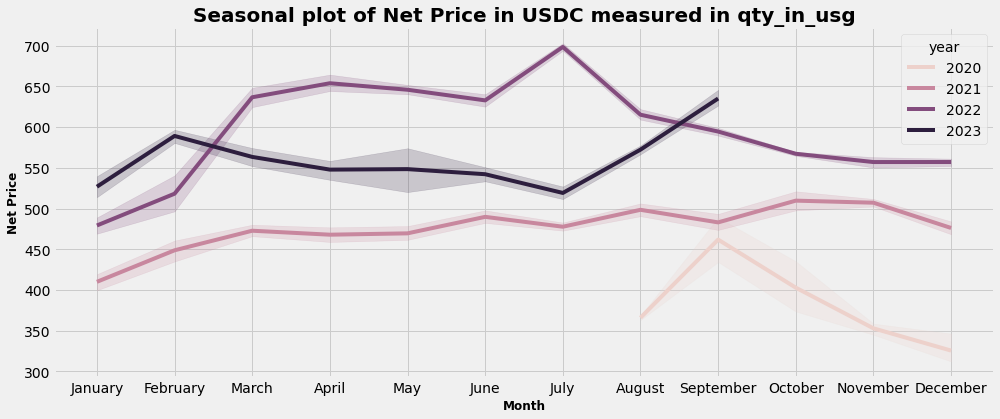

In [51]:
create_seasonal_line_by_year_plot(dict_deli['df_USDC'],'net_price')

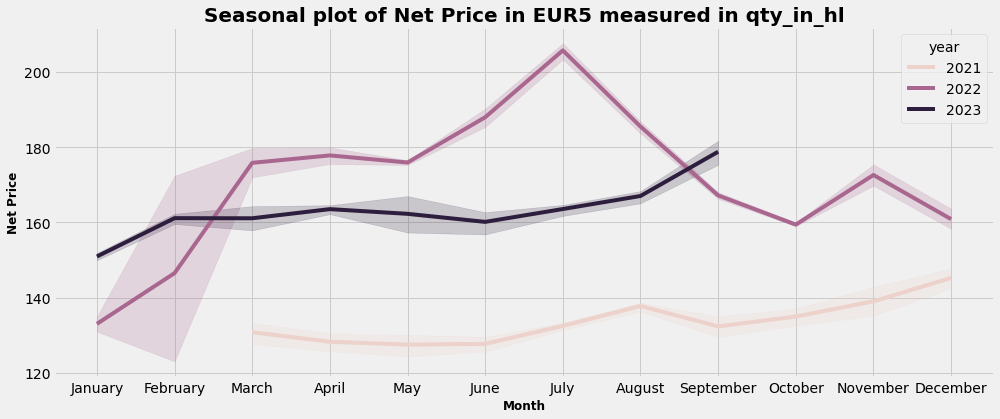

In [52]:
create_seasonal_line_by_year_plot(dict_deli['df_EUR5'],'net_price')

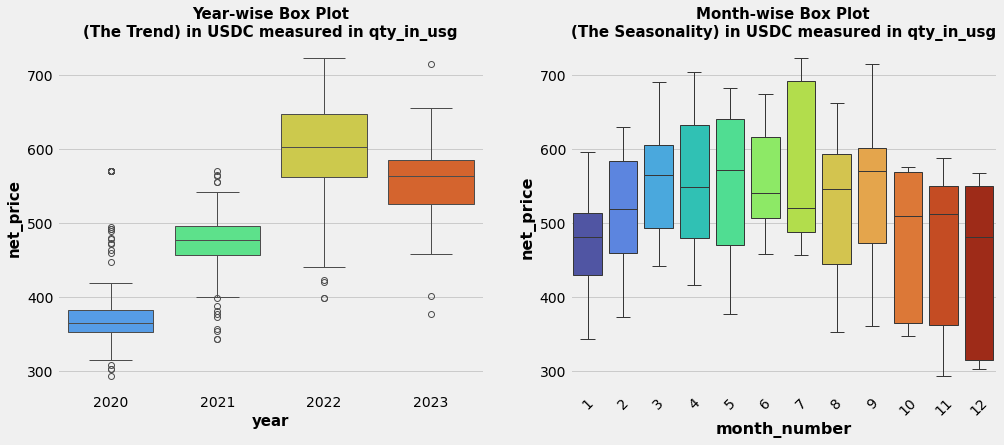

In [156]:
variables='net_price'
plot_box_seasonality(dict_deli['df_USDC'],'year',variables,'month_number')
# median price box plot, price jumps up from March to July and plummeted during 2nd half of the year

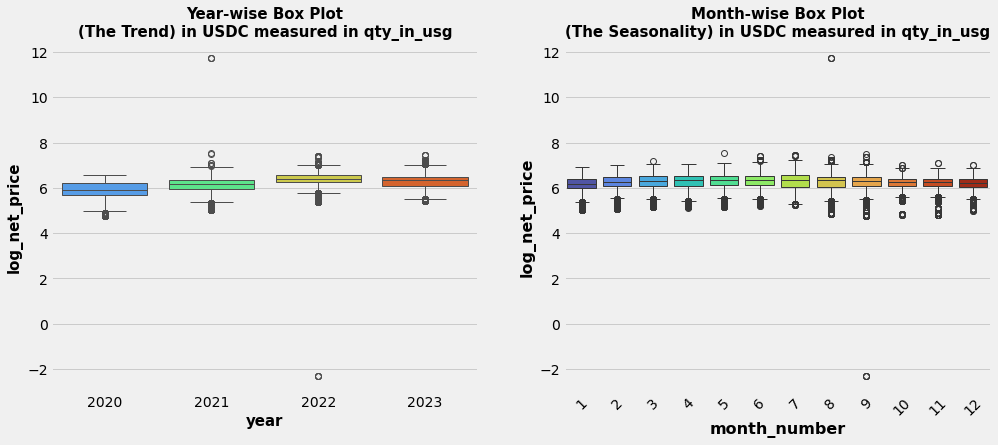

In [157]:
log_price=final_df.loc[final_df['currency_code']=='USDC',['year','month_number','currency_code','qty_mapping','net_price']]
log_price['log_net_price']=np.log(log_price['net_price'])
variables='log_net_price'
plot_box_seasonality(log_price,'year',variables,'month_number')

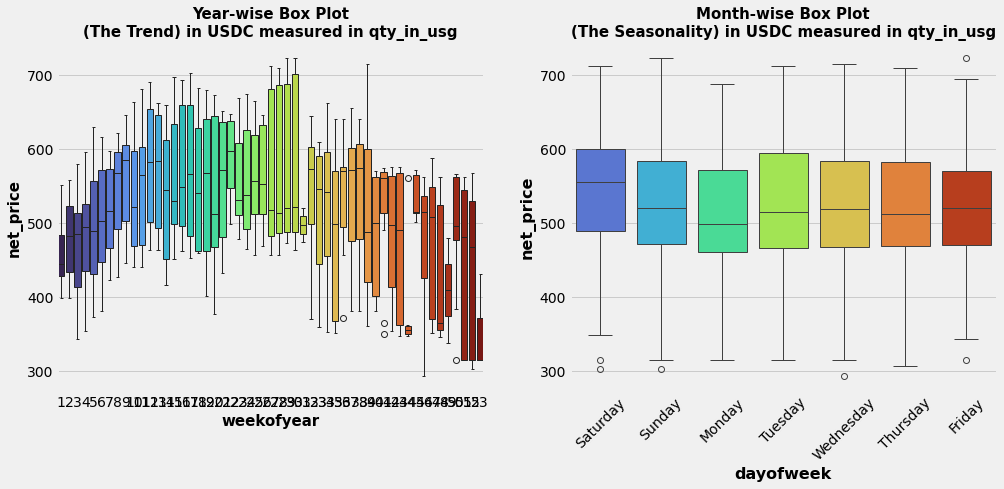

In [158]:
variables='net_price'
plot_box_seasonality(dict_deli['df_USDC'],'weekofyear',variables,'dayofweek')
## No apparent trend in terms of date breakdown

In [80]:
print_qty_currency_df_length_message(final_df,dict_df)

Total Len of dict_df: 787355 
Total Len of df: 829962
Percent of df: 0.95


In [42]:
create_scatter_plot_price_qty(dict_df['df_USDC'])
# low price high volume but when price is within a range<800, demand doesn't see to be impacted 

In [43]:
create_scatter_plot_price_qty(dict_df['df_AUD5'])
# much smaller players but with bulk qty 

In [44]:
create_scatter_plot_price_qty(dict_df['df_NZD5'])

In [45]:
create_scatter_plot_price_qty(dict_df['df_EUR5'],0)

## NO 6: Time Period: YoY, MoM, Customise.  Flags and indicators when performance changes by a certain amount

In [25]:
plot_volume_by_currency_qty_year(dict_df['df_USDC'])

In [47]:
plot_volume_by_currency_qty_year(dict_df['df_EUR5'])

In [48]:
plot_volume_by_currency_qty_year(dict_df['df_AUD5'])

In [49]:
plot_volume_by_currency_qty_year(dict_df['df_NZD5'])

In [56]:
plot_volume_by_currency_qty_year(dict_df['df_DKK4'])
## 2023 volume has gone down by looking at it YOY monthly volume comparison

In [26]:
plot_volume_by_currency_qty_year(dict_df['df_NOK4'])

In [58]:
plot_volume_by_currency_qty_year(dict_df['df_SEK4'])

In [59]:
plot_volume_by_currency_qty_year(dict_df['df_GBPC'])

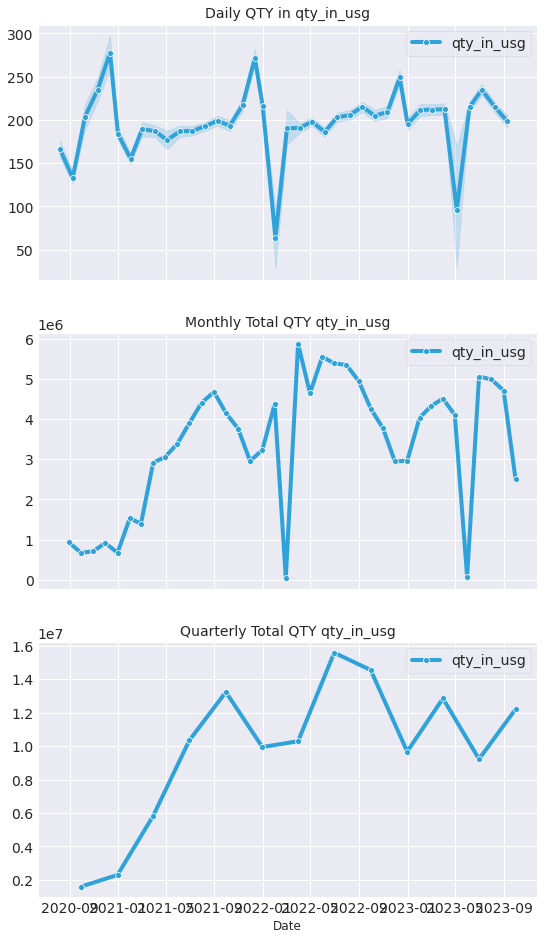

In [165]:
create_resample_graph_qty(dict_df['df_USDC'])
# summary: QTY seems to be cyclical 

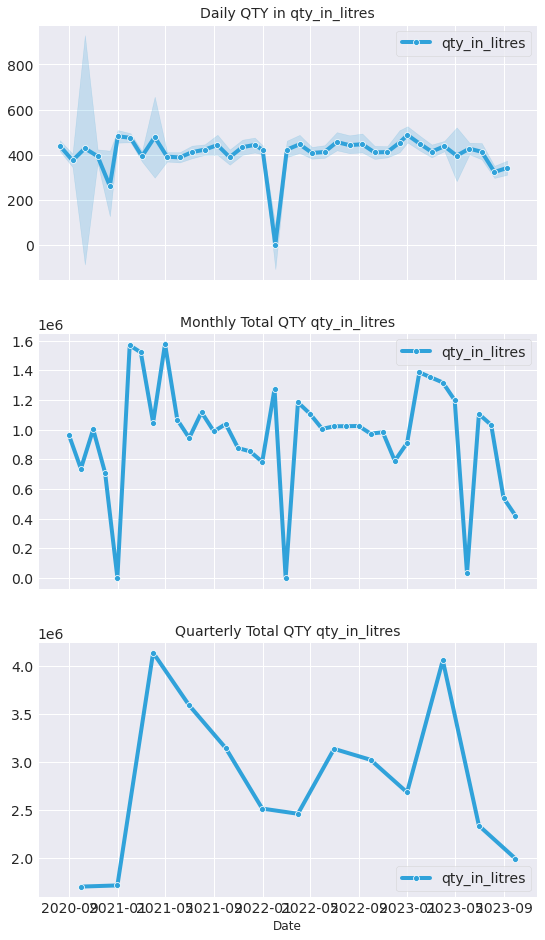

In [166]:
create_resample_graph_qty(dict_df['df_AUD5'])

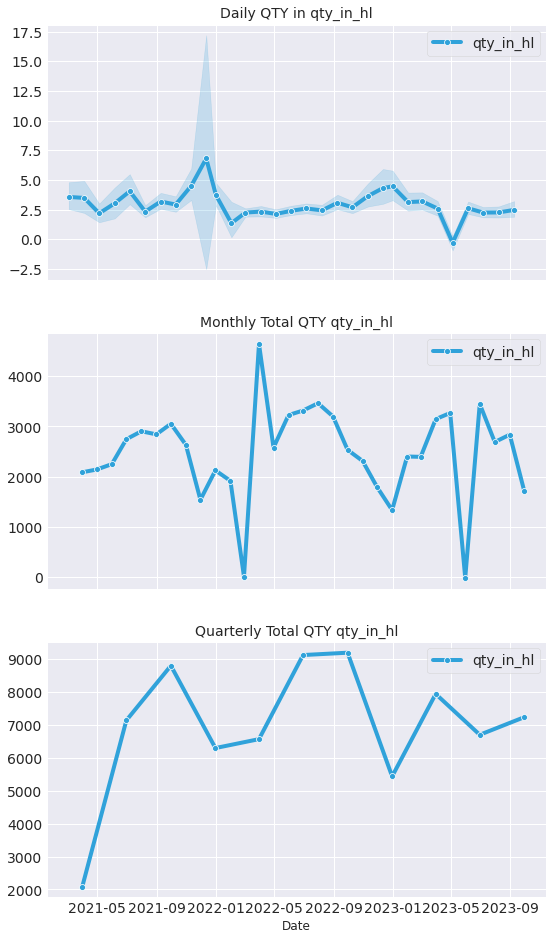

In [167]:
create_resample_graph_qty(dict_df['df_EUR5'])

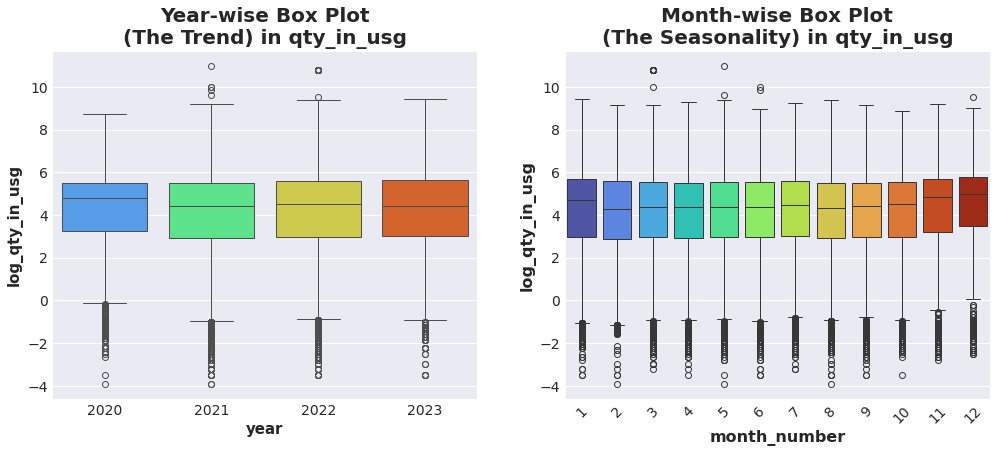

In [168]:
create_log_qty_by_qty_type(dict_df['df_USDC'])

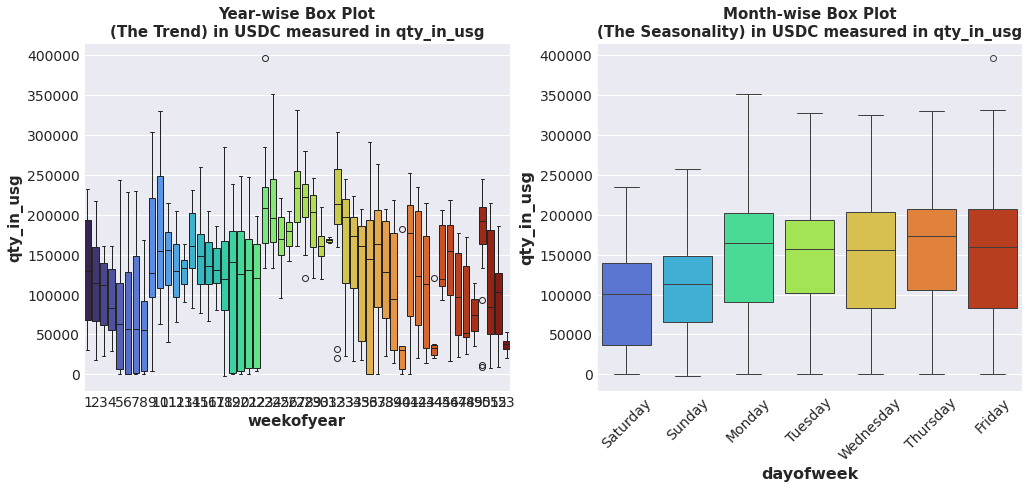

In [169]:
variables='qty_in_usg'
plot_box_seasonality(dict_deli['df_USDC'],'weekofyear',variables,'dayofweek')
## Summary: In terms of dayofweek, qty is higher on Mondays, Thursday and Fridays. And least qty on Sundays and Saturdays

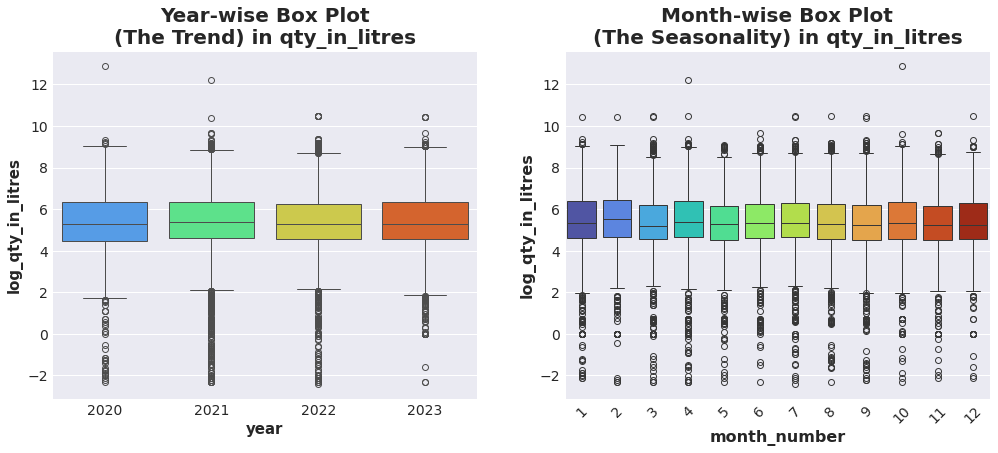

In [170]:
create_log_qty_by_qty_type(dict_df['df_AUD5'])

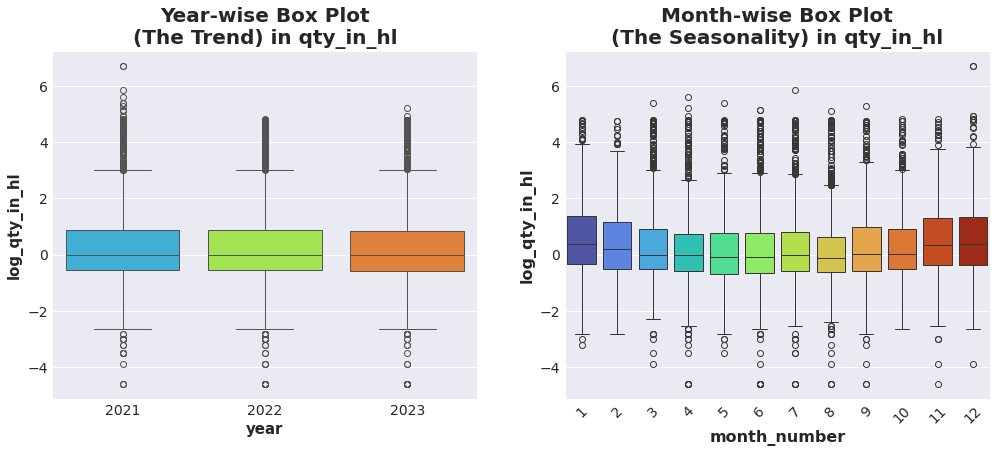

In [171]:
create_log_qty_by_qty_type(dict_df['df_EUR5'])

## EDA Net Price & QTY with extra lenses

In [100]:
print_qty_currency_df_length_message(agg_df,dict_agg)

Total Len of dict_df: 98170 
Total Len of df: 104571
Percent of df: 0.94


## NO.2 Comparison of actual prices at different locations in the same currency comparison e.g., Sterling Card in Swedish Krona – ability to convert in Euro’s and US$ to compare (to discuss)¶

In [27]:
price_median_overall_plots(dict_agg['df_USDC'].loc[dict_agg['df_USDC']['country_name'].isin(usdc_list)],'country_name','product_hierarchy_pa_desc','net_price',
                           'Median Net Price in USDC Overview By Country')

## Q1:Absolute volume by grade

In [28]:
qty_sum_overall_plots(dict_agg['df_USDC'],'year_month','product_hierarchy_pa_desc','Total QTY in USG for USDC currency Overview By Grade (Product Hierarchy)')

In [29]:
qty_sum_overall_plots(dict_agg['df_AUD5'],'year_month','product_hierarchy_pa_desc','Total QTY in Litres for AUD5 Currency Overview By Grade (Product Hierarchy)')

In [63]:
qty_sum_overall_plots(dict_agg['df_EUR5'],'year_month','product_hierarchy_pa_desc','Total QTY in HL for EUR5 Currency Overview By Grade (Product Hierarchy)')

In [30]:
qty_sum_overall_plots(dict_agg['df_USDC'].loc[dict_agg['df_USDC']['country_name'].isin(usdc_list)],'country_name','product_hierarchy_pa_desc','Total QTY in USG Overview By Sales Org')

In [31]:
price_median_overall_plots(dict_agg['df_USDC'].loc[dict_agg['df_USDC']['country_name'].isin(usdc_list)],'country_name','product_code_desc','net_price','Median Net Price in USDC Overview By Sales Org at Product Code Level')

In [32]:
qty_sum_overall_plots(dict_agg['df_USDC'].loc[dict_agg['df_USDC']['country_name'].isin(usdc_list)],'country_name','product_code_desc','Total QTY in USG Overview By Sales Org at Product Code Level')

In [67]:
price_median_overall_plots(dict_agg['df_USDC'],'band_price_cat','product_hierarchy_pa_desc','net_price','Median Net Price in USDC Overview By Band Price at Product Hierarchy Level')

In [ ]:
remove_countries=['']

In [33]:
qty_sum_overall_plots(dict_agg['df_USDC'],'band_price_cat','country_name','Total QTY in USG Overview By Band Price at Country Level')

In [34]:
price_median_overall_plots(dict_agg['df_USDC'],'product_hierarchy_pa_desc','product_code_desc','net_price','Median Net Price in USDC Overview By Product Code')

In [35]:
qty_sum_overall_plots(dict_agg['df_USDC'],'product_hierarchy_pa_desc','product_code_desc','Total QTY in USG Overview By Product Code')

## Revenue 

In [12]:
create_rev_pie_band_price_breakdown_plots(dict_df['df_USDC'])
## SUMMARY: for USDC countries, Sterling card international and PAP international top the chart in terms of revenue with 2022 has the most revenue.
## The top 4 countries with rev are Germany,Norway,France and UK making up more than half of the revenue

In [14]:
create_rev_pie_band_price_breakdown_plots(dict_df['df_DKK4'])
## For DK44 countries, FAROE ISLANDS makes up 76% of the revenue 

In [38]:
create_rev_pie_band_price_breakdown_plots(final_df.loc[final_df.currency_code=='EUR5'],1)

In [39]:
create_rev_pie_band_price_breakdown_plots(final_df.loc[final_df.currency_code=='EUR5'],2)
## For EUR5 & qty_in_litres combo countries, PAP International has the highest revenue. Australia comes frist, followed by Greece and Spain

In [40]:
create_rev_pie_band_price_breakdown_plots(final_df.loc[final_df.currency_code=='EUR5'],0)
## SUMMARY: For EUR5 & qty_in_hl combos, PAP local has the most revenue and Germany has the most revenue

In [41]:
revenue_sum_overall_plots(dict_df['df_USDC'],'country_name','year','Revenue Overview in USDC by Year')
## 2022 has the most revenue

In [43]:
revenue_sum_overall_plots(dict_df['df_USDC'],'product_hierarchy_pa_desc','year','Revenue Overview in USDC by Product Hierarcy')

In [44]:
revenue_sum_overall_plots(dict_df['df_USDC'].loc[dict_df['df_USDC']['year']==2022],'country_name','customer_external_lens','Revenue Overview in USDC by Customer External Lens 2022')
## SUMMARY: Charter/Operator makes up the most of revenue for Germany in terms of revenue, Helicopter for Norway, Charter for France, helicopter for UK

In [45]:
revenue_sum_overall_plots(dict_df['df_USDC'].loc[dict_df['df_USDC']['year']==2022],'product_hierarchy_pa_desc','customer_marketing_segment','Revenue Overview in USDC by Marketing Segment 2022')
# HELP ME GROW for Jet market segment makes up the most of revenuS

In [46]:
revenue_sum_overall_plots(dict_df['df_AUD5'],'country_name','year','Revenue Overview in AUD5 by Year')

In [83]:
revenue_sum_overall_plots(dict_df['df_AUD5'],'product_hierarchy_pa_desc','year','Revenue Overview in AUD5 by Product Hierarchy')

In [84]:
revenue_sum_overall_plots(dict_df['df_AUD5'].loc[dict_df['df_AUD5']['year']==2022],'country_name','customer_external_lens','Revenue Overview in AUD5 by Customer External Lens 2022')

In [85]:
revenue_sum_overall_plots(dict_df['df_AUD5'].loc[dict_df['df_AUD5']['year']==2022],'product_hierarchy_pa_desc','customer_marketing_segment','Revenue Overview in AUD5 by Customer Marketing Segment 2022')

In [86]:
revenue_sum_overall_plots(dict_df['df_DKK4'],'country_name','year','Revenue Overview in DKK4 by Year')

In [88]:
revenue_sum_overall_plots(dict_df['df_DKK4'],'product_hierarchy_pa_desc','year','Revenue Overview in DKK4 by Product Hierarchy')

In [89]:
revenue_sum_overall_plots(dict_df['df_DKK4'].loc[dict_df['df_DKK4']['year']==2022],'country_name','customer_external_lens','Revenue Overview in DKK4 by Customer External Lens 2022')
## Faroe Islands is specifically driven by helicopter service 

In [90]:
revenue_sum_overall_plots(dict_df['df_DKK4'].loc[dict_df['df_DKK4']['year']==2022],'product_hierarchy_pa_desc','customer_marketing_segment','Revenue Overview in DKK4 by Marketing Segment 2022')

In [91]:
revenue_sum_overall_plots(final_df.loc[final_df['currency_code']=='EUR5'],'country_name','year','Revenue Overview in EUR5 by Year',1)

In [93]:
revenue_sum_overall_plots(final_df.loc[final_df['currency_code']=='EUR5'],'product_hierarchy_pa_desc','year','Revenue Overview in EUR5 by Product Hierarchy',1)

In [94]:
revenue_sum_overall_plots(final_df.loc[(final_df['currency_code']=='EUR5') &(final_df['year']==2022)],'country_name','customer_external_lens','Revenue Overview in EUR5 by Customer External Lens 2022',1)

In [95]:
revenue_sum_overall_plots(final_df.loc[(final_df['currency_code']=='EUR5')&(final_df['year']==2022)],'product_hierarchy_pa_desc','customer_marketing_segment','Revenue Overview in EUR5 by Marketing Segment 2022',1)

In [96]:
revenue_sum_overall_plots(final_df.loc[final_df['currency_code']=='EUR5'],'country_name','year','Revenue Overview in EUR5 by Year',2)

In [98]:
revenue_sum_overall_plots(final_df.loc[final_df['currency_code']=='EUR5'],'product_hierarchy_pa_desc','year','Revenue Overview in EUR5 by Product Hierarchy',2)

In [47]:
revenue_sum_overall_plots(final_df.loc[(final_df['currency_code']=='EUR5')&(final_df['year']==2022)],'country_name','customer_external_lens','Revenue Overview in EUR5 by Customer External Lens 2022',2)

In [100]:
revenue_sum_overall_plots(final_df.loc[(final_df['currency_code']=='EUR5')&(final_df['year']==2022)],'product_hierarchy_pa_desc','customer_marketing_segment','Revenue Overview in EUR5 by Marketing Segment 2022',2)

In [101]:
revenue_sum_overall_plots(final_df.loc[final_df['currency_code']=='EUR5'],'country_name','year','Revenue Overview in EUR5 by Year',0)

In [103]:
revenue_sum_overall_plots(final_df.loc[final_df['currency_code']=='EUR5'],'product_hierarchy_pa_desc','year','Revenue Overview in EUR5 by Product Hierarchy',0)

In [104]:
revenue_sum_overall_plots(final_df.loc[(final_df['currency_code']=='EUR5')&(final_df['year']==2022)],'country_name','customer_external_lens','Revenue Overview in EUR5 by Customer External Lens 2022',0)

In [105]:
revenue_sum_overall_plots(final_df.loc[(final_df['currency_code']=='EUR5')&(final_df['year']==2022)],'product_hierarchy_pa_desc','customer_marketing_segment','Revenue Overview in EUR5 by Marketing Segment 2022',0)

In [106]:
revenue_sum_overall_plots(dict_df['df_GBPC'],'country_name','year','Revenue Overview in GBPC by Year')

In [108]:
revenue_sum_overall_plots(dict_df['df_GBPC'],'product_hierarchy_pa_desc','year','Revenue Overview in GBPC by Product Hierarchy')

In [109]:
revenue_sum_overall_plots(dict_df['df_GBPC'].loc[dict_df['df_GBPC']['year']==2022],'country_name','customer_external_lens','Revenue Overview in GBPC by Customer External Lens 2022')

In [110]:
revenue_sum_overall_plots(dict_df['df_GBPC'].loc[dict_df['df_GBPC']['year']==2022],'product_hierarchy_pa_desc','customer_marketing_segment','Revenue Overview in GBPC by Marketing Segment 2022')

## NO.4 COST BREAKDOWN Price Waterfall actual cost trends (total value $ / Unit value $) + local currency conversion + base currency Euro

In [56]:
cost_cols=[ c for c in final_df.columns if 'cost' in str(c) or 'transport' in str(c) or 'l4_pre_airfield' in str(c)  or 'l4_taxes_excise_duty' in str(c) 
           or 'l4_purchase_price' in str(c)]
cost_cols=['qty_in_m3','qty_in_usg','qty_in_litres','qty_in_hl']+cost_cols

cost_df=final_df.groupby(['band_price','year_month','band_price_cat','country_name','product','product_hierarchy_pa_desc','product_code_desc','net_price','sales_org_desc','supply_loc','index_code_desc','uom_code',
                  'currency_code','qty_mapping','start_date','end_date','year','month','month_number','local_currency','customer_country','customer_external_lens','customer_route_to_market',
 'customer_marketing_segment' ],as_index=False)[cost_cols].sum()
cost_df=generate_cost_per_qty_mapping(cost_df)
dict_cost=generate_plot_qty_currency_df(cost_df)

USDC qty_in_usg
AUD5 qty_in_litres
NZD5 qty_in_litres
EUR5 qty_in_litres
SEK4 qty_in_litres
DKK4 qty_in_litres
NOK4 qty_in_litres
GBPC qty_in_litres
CHF5 qty_in_litres
EUR qty_in_litres


In [58]:
create_cost_breakdown_line_plot(dict_cost['df_USDC'],cost_cols)

In [118]:
create_cost_breakdown_line_plot(cost_df.loc[cost_df['currency_code']=='EUR5'],cost_cols,0)

In [119]:
create_cost_breakdown_line_plot(cost_df.loc[cost_df['currency_code']=='EUR5'],cost_cols,1)

In [120]:
create_cost_breakdown_line_plot(cost_df.loc[cost_df['currency_code']=='EUR5'],cost_cols,2)

In [121]:
create_cost_breakdown_line_plot(dict_cost['df_AUD5'],cost_cols)

In [122]:
create_cost_breakdown_line_plot(dict_cost['df_NZD5'],cost_cols,)

In [123]:
create_cost_breakdown_line_plot(dict_cost['df_SEK4'],cost_cols,)

In [124]:
create_cost_breakdown_line_plot(dict_cost['df_GBPC'],cost_cols)

In [125]:
create_cost_breakdown_line_plot(dict_cost['df_NOK4'],cost_cols)

## Q: can't do unit cost, because l3_cost is negative due to cancellation, when do unit cost ,the sum of after divison won't cancel out the negative values ???

In [115]:
def create_cost_per_unit_plot(df,qty_list_no=None):
    """
    Unit cost timeline plots
    
    
    """
    currency_value=df['currency_code'].mode()[0]
    qty_type=df['cost_mapping'].mode()[0]
    if df['currency_code'].mode()[0]=='EUR5':
        qty_lists=['cost_per_qty_in_litres', 'cost_per_qty_in_m3', 'cost_per_qty_in_hl']
        df=df.loc[df['qty_mapping']==qty_lists[qty_list_no]].copy()
        tmp=df.groupby(['year_month'],as_index=False)[lc_cost_cols].sum()
        qty_type=qty_lists[qty_list_no]
    else:
        tmp=df.groupby(['year_month'],as_index=False)[qty_type].sum()
        
    fig=px.line(tmp,'year_month',qty_type,markers='circle')
    fig.update_layout({'title':f'Total Cost Breakdown Overview in {currency_value} measured in {qty_type}'})
    return fig.show('iframe')

In [110]:
tmp=dict_cost['df_USDC']

In [112]:
qty_type=tmp.cost_mapping.mode()[0]

In [130]:
dict_cost['df_USDC'].loc[dict_cost['df_USDC'].year_month=='2020-08'].groupby(['year_month'])['cost_per_qty_in_usg_lc'].min()

year_month
2020-08   -inf
Name: cost_per_qty_in_usg_lc, dtype: float64

In [90]:
cost_df.head()

,band_price,year_month,band_price_cat,country_name,product,product_hierarchy_pa_desc,product_code_desc,net_price,sales_org_desc,supply_loc,index_code_desc,uom_code,currency_code,qty_mapping,start_date,end_date,year,month,month_number,local_currency,customer_country,customer_external_lens,customer_route_to_market,customer_marketing_segment,qty_in_m3,qty_in_usg,qty_in_litres,qty_in_hl,l3_cost_lc,l3_cost_usd,l4_taxes_excise_duty_lc,l4_taxes_excise_duty_usd,l4_other_costs_lc,l4_other_costs_usd,l4_pre_airfield_sh_lc,l4_pre_airfield_sh_usd,l4_pre_airfield_transport_lc,l4_pre_airfield_transport_usd,l4_on_airfield_costs_lc,l4_on_airfield_costs_usd,l4_purchase_price_lc,l4_purchase_price_usd,cost_per_qty_in_m3_lc,cost_per_qty_in_usg_lc,cost_per_qty_in_litres_lc,cost_per_qty_in_hl_lc,cost_mapping
0,10003,2020-08,PAP INTERNATIONAL,AUSTRALIA,0,Non Bio Avgas -L4-040302001,Avgas,470.23,BP Australia,8CUD,XCUD01AE - PROS -CUD/01/AVGAS - Local,UGL,USDC,qty_in_usg,2020-08-08,2020-08-31,2020,August,8,AUD,Australia,Flying Club,Into - Plane Contracted,Make my life easy,0.12,31.56,119.47,1.1947,166.94,122.64,0.0,0.0,0.0,0.0,0.68,0.50,34.39,25.26,38.97,28.63,92.90,68.25,1391.0,5.0,1.0,140.0,cost_per_qty_in_usg_lc
1,10003,2020-08,PAP INTERNATIONAL,AUSTRALIA,0,Non Bio Avgas -L4-040302001,Avgas,471.22,BP Australia,8OO2,XOOL02AE - PROS -OOL/02/AVGAS - Local,UGL,USDC,qty_in_usg,2020-08-08,2020-08-31,2020,August,8,AUD,Australia,Charter/Operator,Into - Plane Contracted,Make my life easy,1.83,483.43,1830.00,18.3000,2417.42,1738.12,0.0,0.0,0.0,0.0,10.42,7.49,540.55,388.66,412.79,296.80,1453.66,1045.17,1321.0,5.0,1.0,132.0,cost_per_qty_in_usg_lc
2,10003,2020-08,PAP INTERNATIONAL,AUSTRALIA,0,Non Bio Avgas -L4-040302001,Avgas,477.25,BP Australia,8DR2,XDRW03AE - PROS -DRW/03/AVGAS - Local,UGL,USDC,qty_in_usg,2020-08-08,2020-08-31,2020,August,8,AUD,Australia,Reseller / Distributor,Into - Plane Contracted,Make my life easy,0.50,131.95,499.47,4.9947,492.97,357.40,0.0,0.0,0.0,0.0,12.55,9.11,68.26,49.49,23.87,17.31,388.29,281.50,986.0,4.0,1.0,99.0,cost_per_qty_in_usg_lc
3,10003,2020-08,PAP INTERNATIONAL,AUSTRALIA,0,Non Bio Avgas -L4-040302001,Avgas,479.95,BP Australia,8JAD,XJAD01AE - PROS -JAD/01/AVGAS - Local,UGL,USDC,qty_in_usg,2020-08-08,2020-08-31,2020,August,8,AUD,Australia,Charter/Operator,Into - Plane Contracted,Make my life easy,1.32,350.03,1325.00,13.2500,1738.11,1276.80,0.0,0.0,0.0,0.0,48.32,35.49,382.13,280.71,260.33,191.24,1047.33,769.36,1317.0,5.0,1.0,131.0,cost_per_qty_in_usg_lc
4,10003,2020-08,PAP INTERNATIONAL,AUSTRALIA,0,Non Bio Avgas -L4-040302001,Avgas,479.95,BP Australia,8JAD,XJAD01AE - PROS -JAD/01/AVGAS - Local,UGL,USDC,qty_in_usg,2020-08-08,2020-08-31,2020,August,8,AUD,Australia,Private pilots,Into - Plane Adhoc,Make my life easy,0.05,12.42,47.00,0.4700,61.88,44.71,0.0,0.0,0.0,0.0,1.71,1.24,13.76,9.94,9.24,6.68,37.17,26.86,1238.0,5.0,1.0,132.0,cost_per_qty_in_usg_lc


In [ ]:
https://medium.com/@miguel.otero.pedrido.1993/hampel-filter-with-python-17db1d265375